# SINet COD10K Detection
Questo notebook implementa SINet per il rilevamento di oggetti mimetizzati.

In [1]:
import os
import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.models as models
import torch.fft as fft
import matplotlib.pyplot as plt
import time
from datetime import timedelta

In [2]:
device = torch.device('mps')

### Parametri ottimali: 
* Adam decay: 1e-4
* Resize: 416 x 416
* Batch: 40
* Epochs: 180 (Provo con 90)

### Dataset Class

In [3]:
class CODDataset(Dataset):
    def __init__(self, image_folder, mask_folder,
                 image_transform=None, mask_transform=None):
        self.image_files = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.image_files[idx].replace('.jpg', '.png'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

    def __len__(self):
        return len(self.image_files)

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(15),
    # transforms.GaussianBlur(kernel_size=(3, 3)),
    transforms.ToTensor()
])

### Backbone encoder (ResNet Multi-scale)
Estrae feature multi-scala con ResNet

In [5]:
class ResNetBackbone(nn.Module):
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        resnet = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        self.stage1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu) 
        self.pool = resnet.maxpool 
        self.stage2 = resnet.layer1  
        self.stage3 = resnet.layer2  
        self.stage4 = resnet.layer3 
        self.stage5 = resnet.layer4  

    def forward(self, x):
        x1 = self.stage1(x)  
        x1p = self.pool(x1)   
        x2 = self.stage2(x1p)  
        x3 = self.stage3(x2)    
        x4 = self.stage4(x3) 
        x5 = self.stage5(x4)  
        return x1, x2, x3, x4, x5  # Feature Multi-Scala

### JDPM (Joint Domain perception module)

In [6]:
class JDPM(nn.Module):
    def __init__(self, in_channels, out_channels=128):
        super(JDPM, self).__init__()
        self.reduce_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)

    def forward(self, x):
        x = self.reduce_channels(x)
        x1 = self.conv1(x)
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        return x1 + x3 + x5

### Entanglement transformer block (ETB)
Modella dipendenze tra frequenze e spazio con self-attention

In [7]:
def normalize_fft(x_freq):
    return (x_freq - x_freq.mean()) / (x_freq.std() + 1e-8)  # Normalizzazione

def filter_fft(x_freq, low_cut=5, high_cut=50):
    # Creiamo una maschera per tenere solo certe frequenze
    mask = (x_freq.abs() > low_cut) & (x_freq.abs() < high_cut)
    return x_freq * mask


In [8]:
class ETB(nn.Module):  
    def __init__(self, in_channels=128):  
        super(ETB, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def fourier_transform(self, x):
        """
        Applica la Trasformata di Fourier 2D e restituisce il modulo.
        """
        x_cpu = x.to("cpu")
        x_freq = fft.fft2(x_cpu, norm="ortho")
        x_freq = fft.fftshift(x_freq)
        magnitude = torch.abs(x_freq)
        return magnitude.to(x.device)

    def inverse_fourier_transform(self, magnitude):
        """
        Torna nello spazio spaziale con IFFT.
        """
        magnitude_cpu = magnitude.to("cpu")
        x_ifft = fft.ifftshift(magnitude_cpu)
        x_spatial = fft.ifft2(x_ifft, norm="ortho").real
        return x_spatial.to(magnitude.device)

    def forward(self, x):
        x_norm = self.norm(x)
        magnitude = self.fourier_transform(x_norm)
        x_combined = magnitude + x_norm
        x_spatial = self.inverse_fourier_transform(x_combined)
        x_out = x_spatial + self.conv1(x_norm)  

        return x_out


### Dual-Domain reverse parser (DRP)

In [9]:
class DRP(nn.Module):
    def __init__(self, in_channels=128):
        super(DRP, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def reverse_attention(self, x, mask):
        return x * (1 - self.sigmoid(mask))

    def forward(self, x, mask):
        x = self.conv(x)
        return self.reverse_attention(x, mask)


### Focal loss

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    Implementazione della Focal Loss per segmentazione binaria.
    Penalizza gli esempi facili e enfatizza quelli difficili.

    Args:
        alpha (float): Peso per la classe positiva (oggetto).
        gamma (float): Fattore di riduzione per gli esempi facili.
    """

    def __init__(self, alpha=0.4, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, preds, targets):
        """
        Calcola la Focal Loss.

        Args:
            preds (torch.Tensor): Predizioni del modello (logits o probabilità).
            targets (torch.Tensor): Maschere ground truth binarie.

        Returns:
            torch.Tensor: Loss focalizzata.
        """

        preds = preds.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        bce_loss = F.binary_cross_entropy(preds, targets, reduction='none')

        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### SINet Class
Combina tutti i moduli e produce output finale

In [11]:
class SINet(nn.Module):
    def __init__(self):
        super(SINet, self).__init__()
        self.backbone = ResNetBackbone()

        # Moduli di FSEL
        self.jdpm = JDPM(in_channels=2048, out_channels=128)
        self.etb = ETB(in_channels=128)
        self.drp = DRP(in_channels=128)

        self.output_conv = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)

        # Fusione spaziale e frequenziale
        x_fused = self.jdpm(x5)

        # Apprendimento entangled di feature frequenziali e spaziali
        x_etb = self.etb(x_fused)

        # Reverse attention per migliorare segmentazione
        x_drp = self.drp(x_etb, x_fused)

        # Mappa finale segmentata
        output = torch.sigmoid(self.output_conv(x_drp))

        return output


### Training

In [12]:
def dice_loss(pred, target, smooth=1.0):
    if pred.shape[2:] != target.shape[2:]:
        pred = F.interpolate(pred, size=target.shape[2:], mode="bilinear", align_corners=False)

    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth))


def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred >= threshold).float()
    
    TP = (pred_bin * target).sum().item()
    FP = (pred_bin * (1 - target)).sum().item()
    FN = ((1 - pred_bin) * target).sum().item()

    precision = TP / (TP + FP + 1e-7)
    recall = TP / (TP + FN + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    iou = TP / (TP + FP + FN + 1e-7)

    return {"iou": iou, "f1": f1}

In [13]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10):
    """
    Funzione per addestrare il modello SINet con FFT.

    Args:
        model: Modello PyTorch (SINet)
        train_loader: DataLoader per il training
        val_loader: DataLoader per la validazione
        optimizer: Ottimizzatore (Adam, SGD, ecc.)
        device: 'cuda', 'mps' o 'cpu'
        num_epochs: Numero di epoche
        save_path: Percorso per salvare il miglior modello

    Returns:
        model: Modello addestrato
    """

    best_val_loss = float("inf")
    model.to(device)

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            predictions = model(images)

            predictions_resized = F.interpolate(predictions, size=masks.shape[2:], mode="bilinear", align_corners=False)
            loss = dice_loss(predictions_resized, masks) + F.binary_cross_entropy(predictions_resized, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        # VALIDATION
        model.eval()
        val_loss = 0.0
        all_iou, all_f1 = [], []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                predictions = model(images)


                predictions_resized = F.interpolate(predictions, size=masks.shape[2:], mode="bilinear", align_corners=False)
                loss = 0.5 * FocalLoss(alpha=0.75, gamma=2.0)(predictions_resized, masks) + 0.5 * dice_loss(predictions_resized, masks)

                val_loss += loss.item()

                predictions_resized = F.interpolate(predictions, size=masks.shape[2:], mode="bilinear", align_corners=False)
                batch_metrics = compute_metrics(predictions_resized, masks)

                all_iou.append(batch_metrics['iou'])
                all_f1.append(batch_metrics['f1'])

        val_loss /= len(val_loader)
        avg_iou = sum(all_iou) / len(all_iou)
        avg_f1 = sum(all_f1) / len(all_f1)

        epoch_duration = timedelta(seconds=time.time() - start_time)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {avg_iou:.4f}, F1: {avg_f1:.4f}, Time: {epoch_duration}")


    print("Training completato!")
    return model

In [14]:
batch_size = 40
num_epochs = 100
lr = 1e-4

train_dataset = CODDataset(
    image_folder="COD10K-v3/Train/Image",
    mask_folder="COD10K-v3/Train/GT_Object",
    image_transform=image_transform,
    mask_transform=mask_transform
)   
val_dataset = CODDataset(
    image_folder="COD10K-v3/Train/Image",
    mask_folder="COD10K-v3/Train/GT_Object",
    image_transform=image_transform,
    mask_transform=mask_transform
)
test_dataset = CODDataset("COD10K-v3/Test/Image",
                        "COD10K-v3/Test/GT_Object",
                        image_transform=image_transform, 
                        mask_transform=mask_transform
                        )

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
model = SINet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

trained_model = train_model(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs)

Epoch [1/100] - Train Loss: 0.8923, Val Loss: 0.2888, IoU: 0.3848, F1: 0.5527, Time: 0:04:34.606401
Epoch [2/100] - Train Loss: 0.6293, Val Loss: 0.2458, IoU: 0.4674, F1: 0.6342, Time: 0:04:32.202518
Epoch [3/100] - Train Loss: 0.5357, Val Loss: 0.2188, IoU: 0.5202, F1: 0.6822, Time: 0:04:24.580949
Epoch [4/100] - Train Loss: 0.4962, Val Loss: 0.2124, IoU: 0.5346, F1: 0.6947, Time: 0:04:31.585988
Epoch [5/100] - Train Loss: 0.4712, Val Loss: 0.2052, IoU: 0.5501, F1: 0.7080, Time: 0:04:33.551503
Epoch [6/100] - Train Loss: 0.4479, Val Loss: 0.1971, IoU: 0.5654, F1: 0.7207, Time: 0:04:33.161820
Epoch [7/100] - Train Loss: 0.4619, Val Loss: 0.1974, IoU: 0.5672, F1: 0.7220, Time: 0:04:35.274667
Epoch [8/100] - Train Loss: 0.4390, Val Loss: 0.1929, IoU: 0.5741, F1: 0.7275, Time: 0:04:35.686915
Epoch [9/100] - Train Loss: 0.4250, Val Loss: 0.1902, IoU: 0.5786, F1: 0.7314, Time: 0:04:36.105355
Epoch [10/100] - Train Loss: 0.4188, Val Loss: 0.1872, IoU: 0.5850, F1: 0.7364, Time: 0:04:32.600972

In [16]:
torch.save(model.state_dict(), "sinet_best.pth")

In [17]:
def compute_batch_metrics(pred, target, threshold=0.5):
    """
    Calcola accuracy, precision, recall, F1-score e IoU per un batch di immagini.

    Args:
        pred (torch.Tensor): Predizioni del modello (logits o probabilità)
        target (torch.Tensor): Maschere ground truth binarie
        threshold (float): Soglia per binarizzare le predizioni

    Returns:
        dict: Dizionario con le metriche medie sul batch
    """

    # 🟢 Ridimensiona pred per matchare target
    if pred.shape[2:] != target.shape[2:]:
        pred = F.interpolate(pred, size=target.shape[2:], mode="bilinear", align_corners=False)

    pred_bin = (pred >= threshold).float()

    eps = 1e-7
    batch_size = pred.shape[0]

    acc_list, prec_list, rec_list, f1_list, iou_list = [], [], [], [], []

    for i in range(batch_size):
        p = pred_bin[i].view(-1)  # Flatten per batch
        t = target[i].view(-1)  

        TP = (p * t).sum().item()
        FP = (p * (1 - t)).sum().item()
        FN = ((1 - p) * t).sum().item()
        TN = ((1 - p) * (1 - t)).sum().item()

        acc = (TP + TN) / (TP + TN + FP + FN + eps)
        prec = TP / (TP + FP + eps)
        rec = TP / (TP + FN + eps)
        f1 = 2 * prec * rec / (prec + rec + eps)
        iou = TP / (TP + FP + FN + eps)

        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)
        iou_list.append(iou)

    metrics = {
        'accuracy': np.mean(acc_list),
        'precision': np.mean(prec_list),
        'recall': np.mean(rec_list),
        'f1': np.mean(f1_list),
        'iou': np.mean(iou_list)
    }
    return metrics

In [18]:
def test_model(model, test_loader, device, threshold=0.5):
    """
    Testa il modello su un dataset di test e calcola le metriche medie.

    Args:
        model (torch.nn.Module): Modello addestrato
        test_loader (DataLoader): DataLoader con il dataset di test
        device (str): 'cuda', 'mps' o 'cpu'
        threshold (float): Soglia per binarizzare le predizioni

    Returns:
        dict: Dizionario con le metriche medie su tutto il dataset di test
    """
    model.to(device)
    model.eval()

    all_acc, all_prec, all_rec, all_f1, all_iou = [], [], [], [], []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            out_final = model(images)

            # 🟢 Calcola metriche per batch
            batch_metrics = compute_batch_metrics(out_final, masks, threshold)
            all_acc.append(batch_metrics['accuracy'])
            all_prec.append(batch_metrics['precision'])
            all_rec.append(batch_metrics['recall'])
            all_f1.append(batch_metrics['f1'])
            all_iou.append(batch_metrics['iou'])

    # 🟢 Media finale delle metriche su tutto il test set
    avg_metrics = {
        'accuracy': np.mean(all_acc),
        'precision': np.mean(all_prec),
        'recall': np.mean(all_rec),
        'f1': np.mean(all_f1),
        'iou': np.mean(all_iou)
    }
    return avg_metrics

In [19]:
# 🟢 Testa il modello
test_metrics = test_model(model, test_loader, device, threshold=0.5)

# 📊 Stampa i risultati finali
print("\n🎯 **RISULTATI TEST FINALI:**")
print(f"  Accuracy  = {test_metrics['accuracy']:.3f}")
print(f"  Precision = {test_metrics['precision']:.3f}")
print(f"  Recall    = {test_metrics['recall']:.3f}")
print(f"  F1-score  = {test_metrics['f1']:.3f}")
print(f"  IoU       = {test_metrics['iou']:.3f}")


🎯 **RISULTATI TEST FINALI:**
  Accuracy  = 0.963
  Precision = 0.201
  Recall    = 0.148
  F1-score  = 0.155
  IoU       = 0.115


In [20]:
def show_random_predictions(model, test_loader, device, num_samples=5, threshold=0.5):
    """
    Mostra immagini casuali dal dataset di test con la loro maschera e la predizione del modello.

    Args:
        model: Modello PyTorch addestrato (SINet)
        test_loader: DataLoader con il dataset di test
        device: 'cuda', 'mps' o 'cpu'
        num_samples: Numero di immagini da visualizzare
        threshold: Soglia per binarizzare le predizioni
    """
    model.to(device)
    model.eval()

    # Estrai batch casuale dal test_loader
    images, masks = next(iter(test_loader))

    # 🟢 Evita di selezionare più immagini di quante ne siano disponibili
    num_samples = min(num_samples, images.shape[0])  # Non supera il batch size

    # Seleziona un sottoinsieme casuale di immagini dal batch
    indices = random.sample(range(len(images)), num_samples)
    images, masks = images[indices], masks[indices]

    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        predictions = model(images)

    # 🟢 Ridimensiona predictions per matchare masks
    predictions_resized = F.interpolate(predictions, size=masks.shape[2:], mode="bilinear", align_corners=False)

    # 🟢 Applica threshold alle predizioni per ottenere maschere binarie
    predictions_binary = (predictions_resized >= threshold).float()

    # 📊 Mostra le immagini originali, maschere e predizioni
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Converti da tensor a numpy
        mask = masks[i].squeeze().cpu().numpy()
        pred = predictions_binary[i].squeeze().cpu().numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Immagine originale")
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Maschera reale")
        axes[i, 2].imshow(pred, cmap="gray")
        axes[i, 2].set_title("Predizione modello")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

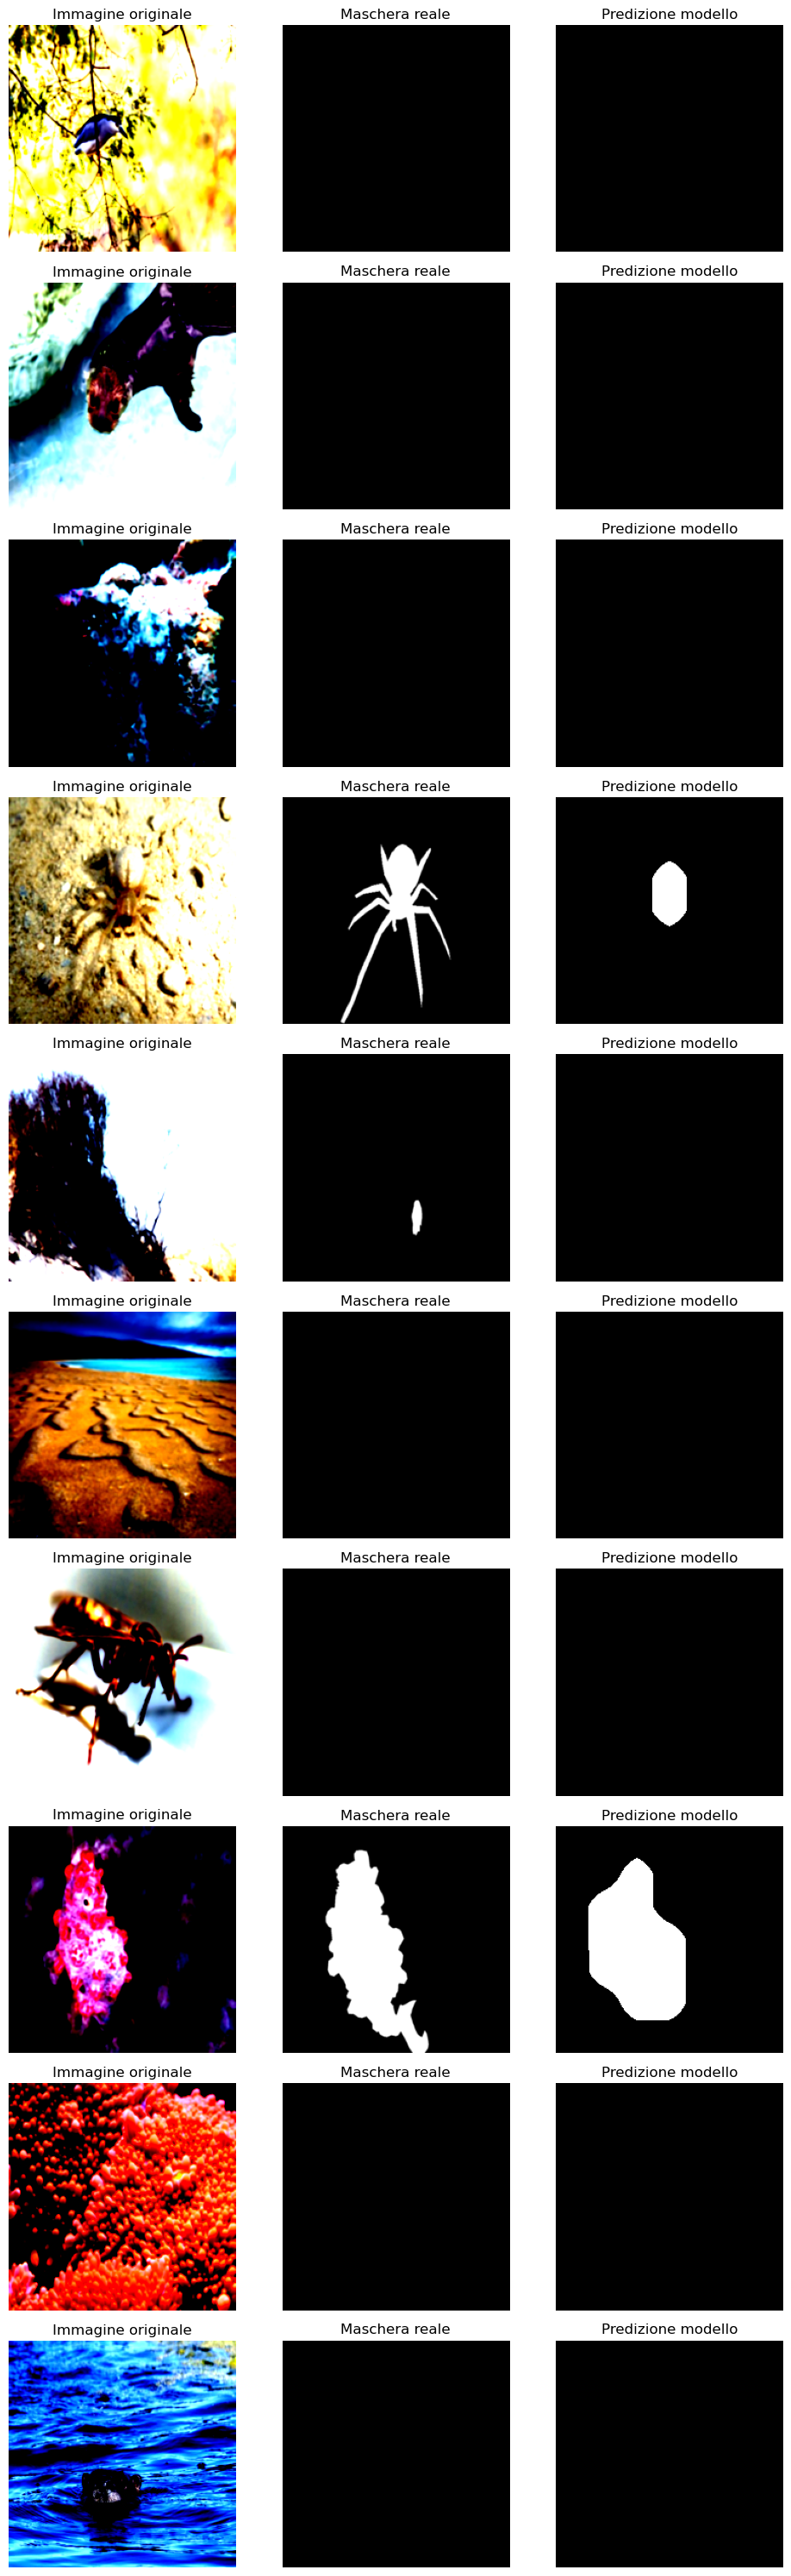

In [24]:
show_random_predictions(model, test_loader, device, num_samples=10)   # Mostrerà 10 immagini
